### Find Files

In [19]:
import docx
import os
import sys
import numpy as np
import pandas as pd
import PyPDF2
from docx import Document
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from collections import defaultdict

src_path = os.path.abspath(os.path.join("..", "src"))
sys.path.append(src_path)

from portfolio_optimization import *
from backtest import *

files = os.listdir(src_path)

substring_to_find = "sharpe_summary_filtered"

matching_files = []
for s in files:
    if substring_to_find in s:
        matching_files.append(s)

matching_files.sort()

In [20]:
for i in matching_files:
    print(i)

etf_sharpe_summary_filtered_2000_2004.csv
etf_sharpe_summary_filtered_2001_2005.csv
etf_sharpe_summary_filtered_2002_2006.csv
etf_sharpe_summary_filtered_2003_2007.csv
etf_sharpe_summary_filtered_2010_2014.csv
etf_sharpe_summary_filtered_2011_2015.csv
etf_sharpe_summary_filtered_2014_2018.csv


### Create Dictionary of files

In [21]:
df_dict = {}

for i in matching_files:
    
    df_dict["df_" + i[28:32]] = optimize_portfolio(
        "../src/" + i, int(i[28:32])
    )

### Run Backtest on each file

In [22]:
dfs = []

for key in list(df_dict.keys()):
    print(key)
    year = int(key[3:8])
    
    weights_df = pd.DataFrame(df_dict[key])[["Ticker","Weight"]]
    weights_df = weights_df.rename(columns={"Ticker":"ticker"})
    weights_df["ticker"] = weights_df["ticker"].astype(str).str.strip().str.strip("'").str.strip('"').str.upper()

    table, port_eq, bench_eq = run_single_5y_capital_6040(
        weights_df,
        start=str(year+5)+"-01-01",     # month-end recommended
        end=str(year+10)+"-01-01",       # optional; will clip to 5y if not given
        capital=250_000,
        use_integer_shares=True # set False for fractional shares
    )
    
    dfs.append(table)

df_2000
df_2001
df_2002
df_2003
df_2010
df_2011
df_2014


In [23]:
results = pd.concat(dfs)

In [24]:
results

,Name,Start,End,Return,Volatility,Alpha,Beta,Sharpe
0,Portfolio,2005-01-31,2009-12-31,0.331158,0.224417,0.021616,2.178653,0.378006
1,60/40 (SPY/AGG),2005-01-31,2009-12-31,0.126690,0.097102,0.000000,1.000000,0.299815
0,Portfolio,2006-01-31,2010-12-31,0.338614,0.256343,0.002262,2.361027,0.366455
1,60/40 (SPY/AGG),2006-01-31,2010-12-31,0.179527,0.100999,0.000000,1.000000,0.384461
0,Portfolio,2007-01-31,2011-12-31,-0.038200,0.274740,-0.042254,2.551712,0.114068
1,60/40 (SPY/AGG),2007-01-31,2011-12-31,0.124924,0.101245,0.000000,1.000000,0.288117
0,Portfolio,2008-01-31,2012-12-31,-0.000693,0.245876,-0.062202,2.145525,0.127262
1,60/40 (SPY/AGG),2008-01-31,2012-12-31,0.209685,0.105457,0.000000,1.000000,0.421371
0,Portfolio,2015-01-31,2019-12-31,0.485285,0.174508,-0.073923,1.947432,0.551670
1,60/40 (SPY/AGG),2015-01-31,2019-12-31,0.522737,0.076250,0.000000,1.000000,1.163864


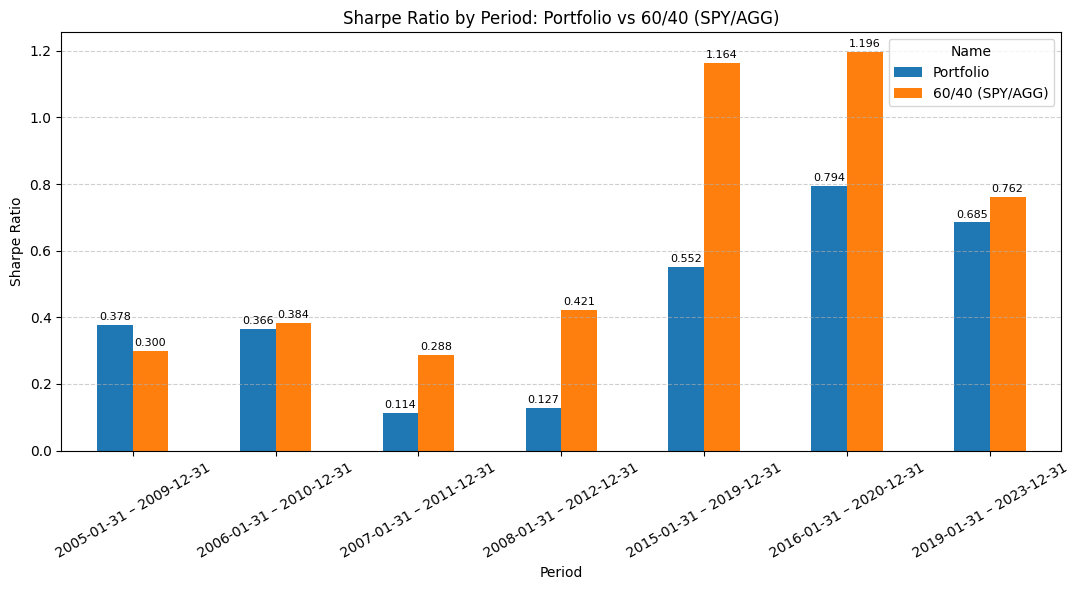

In [26]:
import matplotlib.pyplot as plt

results["Period"] = results["Start"] + " – " + results["End"]

# Pivot to have one column per portfolio to plot side-by-side bars by period
plot_df = results.pivot_table(index="Period", columns="Name", values="Sharpe", aggfunc="first")
plot_df = plot_df[["Portfolio", "60/40 (SPY/AGG)"]]  # ensure consistent order

# Create bar chart
ax = plot_df.plot(kind="bar", figsize=(11, 6))
ax.set_xlabel("Period")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio by Period: Portfolio vs 60/40 (SPY/AGG)")
ax.tick_params(axis="x", rotation=30)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=8)

plt.tight_layout()
plt.show()

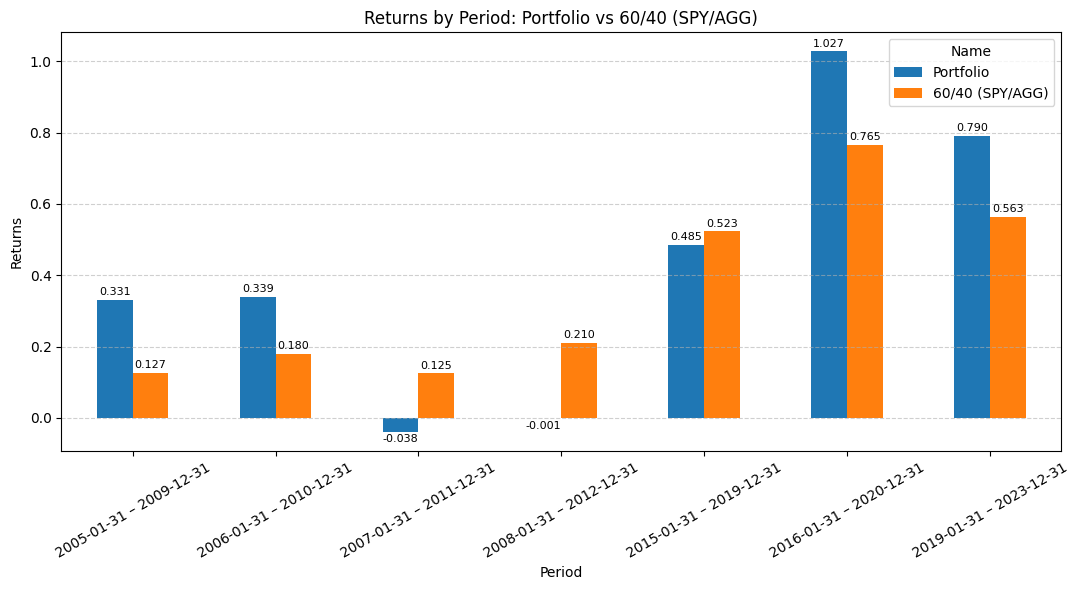

In [27]:
# Pivot to have one column per portfolio to plot side-by-side bars by period
plot_df = results.pivot_table(index="Period", columns="Name", values="Return", aggfunc="first")
plot_df = plot_df[["Portfolio", "60/40 (SPY/AGG)"]]  # ensure consistent order

# Create bar chart
ax = plot_df.plot(kind="bar", figsize=(11, 6))
ax.set_xlabel("Period")
ax.set_ylabel("Returns")
ax.set_title("Returns by Period: Portfolio vs 60/40 (SPY/AGG)")
ax.tick_params(axis="x", rotation=30)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=8)

plt.tight_layout()
plt.show()

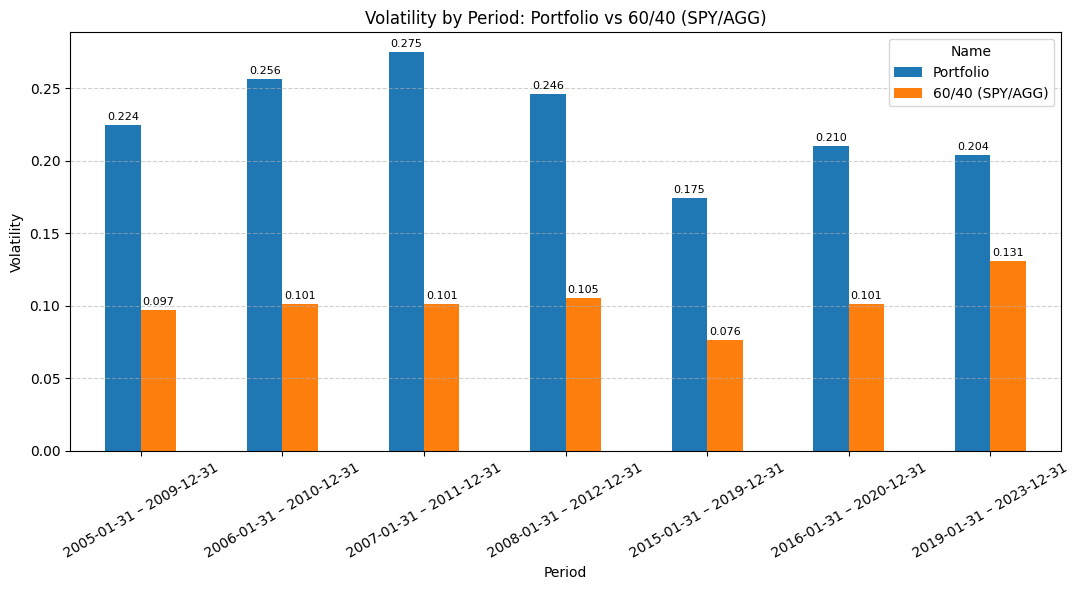

In [28]:
# Pivot to have one column per portfolio to plot side-by-side bars by period
plot_df = results.pivot_table(index="Period", columns="Name", values="Volatility", aggfunc="first")
plot_df = plot_df[["Portfolio", "60/40 (SPY/AGG)"]]  # ensure consistent order

# Create bar chart
ax = plot_df.plot(kind="bar", figsize=(11, 6))
ax.set_xlabel("Period")
ax.set_ylabel("Volatility")
ax.set_title("Volatility by Period: Portfolio vs 60/40 (SPY/AGG)")
ax.tick_params(axis="x", rotation=30)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=8)

plt.tight_layout()
plt.show()